# Simulation of Physical System - to be used by Learning Algo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import CoolProp.CoolProp as CP

$m \cdot a = F$ <br>
$\ddot{x}= \frac{1}{m} \cdot (F_T - F_G - F_H + F_R )$<br>
$\ddot{x}= \frac{1}{m} \cdot (F_T - (m \cdot * g_0) - (k \cdot x) + (sign(\dot{x}) \cdot 10N) )$

In [58]:
H = CP.PropsSI('H','P',300 * 1e5,'T',293, "Nitrogen") # assume Enthalpy constant ofer the whole system

def F_Thrust(p_valve):
    R = 296.8 # Gas constant of Nitrogen
    gamma = 1.4
    D_th = 9 # nozzle throat diameter mm
    D_ex = 11 # nozzle exit diameter mm
    A_th = (D_th/4)**2*np.pi
    A_ex = (D_ex/4)**2*np.pi

    # values over the mach shock
    p_1 = p_valve
    T_1 = CP.PropsSI('T','P',p_1 * 1e5,'H',H, "Nitrogen") # [K]
    
    md = ((A_th*p_1)/np.sqrt((T_1*R)/gamma)*((gamma+1)/2))**((-gamma-1)/(2*(gamma-1)))
    
    M_ex = 1.5 # Initial value for the exit Mach number
    
    for j in range(0 ,1):
        M_ex = (A_th*A_ex)*((gamma+1)/2)**((-gamma-1)/(2*(gamma-1)))*(1+((gamma-1)/2)*M_ex**2)**((gamma+1)/2*(gamma-1))
    
    T_2 = ((1 + ((gamma - 1)/2)*M_ex**2)**(-1))*T_1
    p_2 = ((1 + ((gamma - 1)/2)*M_ex**2)**(-gamma/(gamma - 1)))*p_1
    
    v_ex = M_ex * np.sqrt(gamma*R*T_2)
    
    F_T = md * v_ex + (p_1 - p_2) * A_ex

    return F_T

F_Thrust(10)

1570.42224344943

In [59]:
# 𝐹𝑅𝑅 ≈ 10𝑁 Rolling - Resistance against velocity
# FG = m

g0 = 9.80665

m = 3.5 # kg
F_T = 34.5 #F_Thrust(10) # N
F_RR = 10 # N
k  = 6 # N /m

# resistance modelling - smoothed to stablize model
def F_R(v):
    v_thr = 0.01
    
    if abs(v) > v_thr:
        F_R = np.sign(v)*F_RR
    else:
        F_R = (abs(v)/v_thr)*np.sign(v)*F_RR
    return F_R

def ode(t, y):
    """
    Defines the system of ODEs for free fall.

    Parameters:
        t (float): Time.
        y (array): Array containing the position and velocity [x, v].

    Returns:
        dydt (array): Array containing the derivatives [v, a].
    """
    global F_T
    
    x = y[0]
    v = y[1]
    
    a = (1/m)*(F_T - (m*g0) - (k *x) - (F_R(v)))
    dydt = np.array([v, a])
    return dydt

def rk4_e(f, y, h, t): # runge kutta 4th order explicit
    # runge kutte 4th order explicit
    tk_05 = t + 0.5*h
    yk_025 = y + 0.5 * h * f(t, y)
    yk_05 = y + 0.5 * h * f(tk_05, yk_025)
    yk_075 = y + h * f(tk_05, yk_05)
    
    return y + h/6 * (f(t, y) + 2 * f(tk_05, yk_025) + 2 * f(tk_05, yk_05) + f(t+h, yk_075))

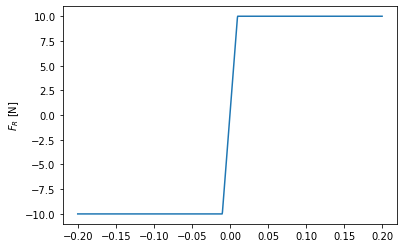

In [60]:
# resistance modelling - smoothed to stablize model
x = np.linspace(-0.2,0.2,1000)
y = []
for i in x:
    y.append(F_R(i))
plt.plot(x, y)
plt.ylabel('$F_{R}$ [N]')
plt.show()

In [67]:
h = 1/1000              # stepsize in seconds
t0 = 0                  # initial time in seconds
tn = 10                  # final time in seconds

time = np.linspace(t0, tn, int((tn-t0)/h)+1)
n = len(time)

y0_ode = np.array([0,0]) # initial x, v

states_ode = np.zeros((len(y0_ode), n))

y_ode = y0_ode

for ii, t in enumerate(time):

    states_ode[:, ii] = y_ode
            
    y_ode = rk4_e(ode, y_ode, h, t)
    
    #print(f'Step {ii+1} of {n}'.format(),end="\r",flush=True)

print('done')
position = states_ode[0,:]
velocity = states_ode[1,:]

done


In [68]:
# Initial conditions [initial_position, initial_velocity]
#initial_conditions = [0, 0]

# Time span for the simulation (0 to 5 seconds, for example)
#t_span = (0, 5)

# Solve the ODE using solve_ivp
#solution = solve_ivp(ode, t_span, initial_conditions, method='RK45')

# Extract results
#time = solution.t
#position = solution.y[0]
#velocity = solution.y[1]

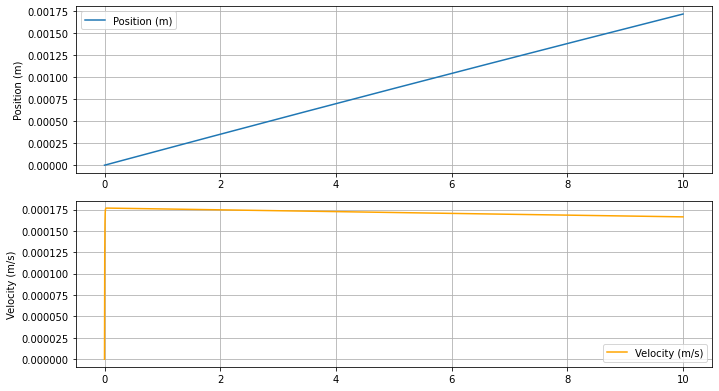

In [69]:
# Plotting the results
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(time, position, label='Position (m)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)

plt.subplot(312)
plt.plot(time, velocity, label='Velocity (m/s)', color='orange')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [91]:
def sim_step(y,p=None):
    h = 1/600              # stepsize in seconds
    t0 = 0                  # initial time in seconds
    tn = 1/60               # final time in seconds
    
    time = np.linspace(t0, tn, int((tn-t0)/h)+1)

    # update Thrust
    global F_T
    F_T = 34.5 #F_Thrust(p)
    
    for t in time:
        y = rk4_e(ode, y, h, t)
        
    return y

In [92]:
y = np.array([0,0])
for i in range(10*60):
    y = sim_step(y) # sim_step(y,p=10)
y

array([0.00188067, 0.00016544])

In [ ]:
# array([0.00171476, 0.00016644])